# Traffic Sign Recognition Project
---
## Name: Zhenli Jin

As autonomous driving and self-driving car become more and more popular, many emerging technologies, such as high precision radar, high-definition camera, LiDAR (light detection and ranging), artificial intelligence algorithms and so on, are being applied to autonomous driving. Road traffic safety is important to vehicles and drivers, so automotive suppliers developed driver-assistance system and traffic-sign recognition is one of the features of the assisted control system. Recognizing traffic signs correctly is important, since this is related to speed of vehicles, whether or not to stop, merging into one lane, and so on. In addition, every country has its own traffic signs system and the signs are largely identical but with slight differences. Thus, building an effective algorithm is necessary for the development of autonomous driving.

In this project, we will build a convolutional neural network to recognize the traffic signs. Also, given a new traffic sign image, we will test if the recoginizer could recognize the image correctly.

<a id='top'></a>
## Table of Contents

1. [Data Preparation](#dataprepare)
2. [Exploratory Data Analysis](#eda)
3. [Building a CNN Model](#cnn)
4. [Train and Validate the Model](#train)

<a id='dataprepare'></a>
## 1 Data Preparation

The dataset is public and available at [Kaggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign).

According to the description on Kaggle page, the traffic signs originated from German and it was a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. The dataset contains more than 50000 images of different traffic signs stored in three folders: Train, Test, and Meta. Our first step is to import the dataset and to convert it into the proper form.

In [29]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
# pip install natsort
from natsort import os_sorted
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG19

from sklearn.metrics import accuracy_score

Let's first check the number of classes of the traffic signs.

In [2]:
# Check the number of categories in the Train dataset
num_classes = len(os.listdir(os.path.join(os.getcwd(), 'Train')))
num_classes

43

Note that we have 43 folders, which is 43 different signs or classes, in the Train folder.

In [4]:
images = []
labels = []
for i in range(num_classes):
    categories = os.path.join(os.getcwd(), 'Train', str(i))
    for img in os.listdir(categories):
        img = load_img(os.path.join(categories, img), target_size=(50, 50))
        image = img_to_array(img)
        images.append(image)
        labels.append(i)

In [5]:
# Convert the data into numpy arrays for model building
training = np.array(images)
labels_ = to_categorical(np.array(labels))

In [6]:
# Check data size
print(training.shape, labels_.shape)

(39209, 50, 50, 3) (39209, 43)


The shape of training data is (39209, 50, 50, 3), so we have 39209 training images and eash image is resized to 50 by 50, and the image has 3 channels. That is the image is colored (RGB image). In addition, the shape of labels is consistent that having 39209 labels.

In [7]:
# One-hot encoding labels
labels_

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

[Back to top](#top)

<a id='eda'></a>
## 2 Exploratory Data Analysis

Now we only have the numerical labels for each sign, i.e., 0, 1, 2, ..., 41, 42. We want to know what each traffic sign represents for. Note that there is a folder Meta containing standard traffic sign for these 43 signs. Let's first see how these standard signs look like, and by checking online, we could obtain the official and standard label names.

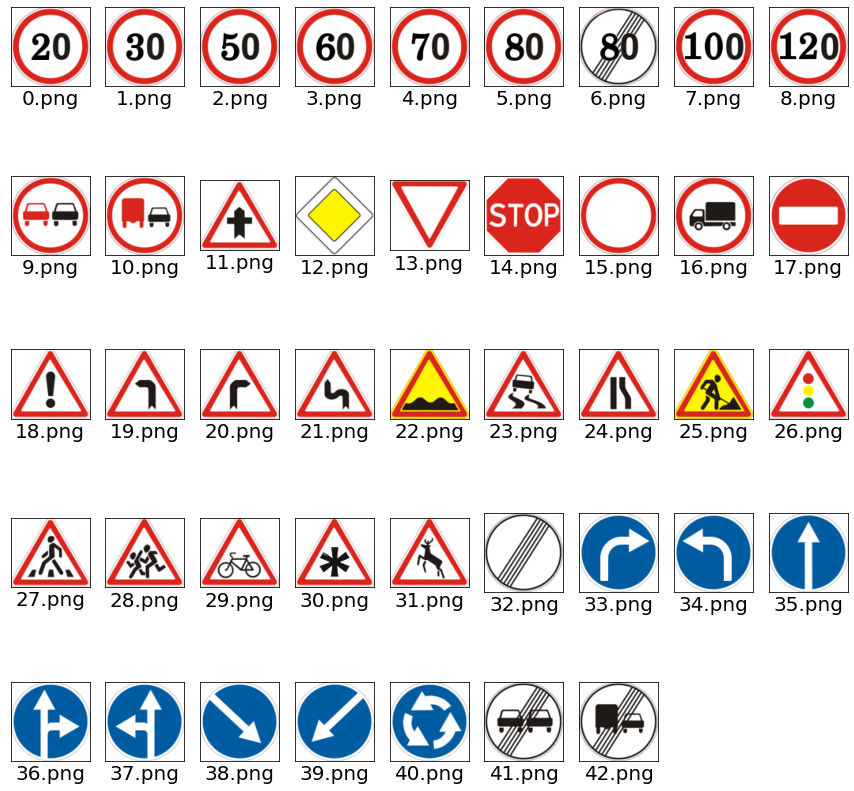

In [8]:
plt.figure(figsize=(15, 15))
for i, png in enumerate(os_sorted(os.listdir('Meta')), 1):
    plt.subplot(5, 9, i)
    image_path = os.path.join(os.getcwd(), 'Meta', str(png)).replace('\\', '/')
    img = mpimg.imread(image_path)
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(str(png), fontsize=20)

By looking up these signs online, we have the labels as following. Note that the signs were from German.

Reference: [Road Signs in Germany](https://routetogermany.com/drivingingermany/road-signs)

In [9]:
sign_labels = {
    0: 'Maximum Speed limit (20km/h)',
    1: 'Maximum Speed limit (30km/h)', 
    2: 'Maximum Speed limit (50km/h)', 
    3: 'Maximum Speed limit (60km/h)', 
    4: 'Maximum Speed limit (70km/h)', 
    5: 'Maximum Speed limit (80km/h)', 
    6: 'End of maximum speed limit (80km/h)', 
    7: 'Maximum Speed limit (100km/h)', 
    8: 'Maximum Speed limit (120km/h)', 
    9: 'No passing', 
    10: 'No passing for vehicles over 3.5 tons', 
    11: 'Right-of-way at the next intersection', 
    12: 'Priority road', 
    13: 'Yield', 
    14: 'Stop', 
    15: 'No entry for vehicles', 
    16: 'No entry for vehicles over 3.5 tons', 
    17: 'Do not enter', 
    18: 'General danger', 
    19: 'Single curve left', 
    20: 'Single curve right', 
    21: 'Double curve', 
    22: 'Rough road', 
    23: 'Slippery road', 
    24: 'Road narrows from the right', 
    25: 'Road work in process', 
    26: 'Traffic signal', 
    27: 'Pedestrians crossing ahead', 
    28: 'Children crossing ahead', 
    29: 'Bicycles crossing ahead', 
    30: 'Icy road ahead',
    31: 'Wild animals crossing ahead', 
    32: 'End passing and speed restriction', 
    33: 'Must turn right', 
    34: 'Must turn left', 
    35: 'Straight ahead only', 
    36: 'Straight or right', 
    37: 'Straight or left', 
    38: 'Keep right', 
    39: 'Keep left', 
    40: 'Entrance to a traffic circle', 
    41: 'End of no passing zone', 
    42: 'End of no passing for vehicles over 3.5 tons' 
}

Note that since this is a classification task, the distribution of the dataset is important. We also visualize the dataset by showing how many images under each class.

In [10]:
# Obtain the number of images by each class
num_each_class = dict.fromkeys([key for key in sign_labels.values()])
for i in range(num_classes):
    categories = os.path.join(os.getcwd(), 'Train', str(i))
    num_each_class[list(num_each_class.keys())[i]] = (len(os.listdir(categories)))

# Sort by the numbers of images
num_each_class_sorted = {k:v for k,v in sorted(num_each_class.items(), key=lambda item: item[1])}

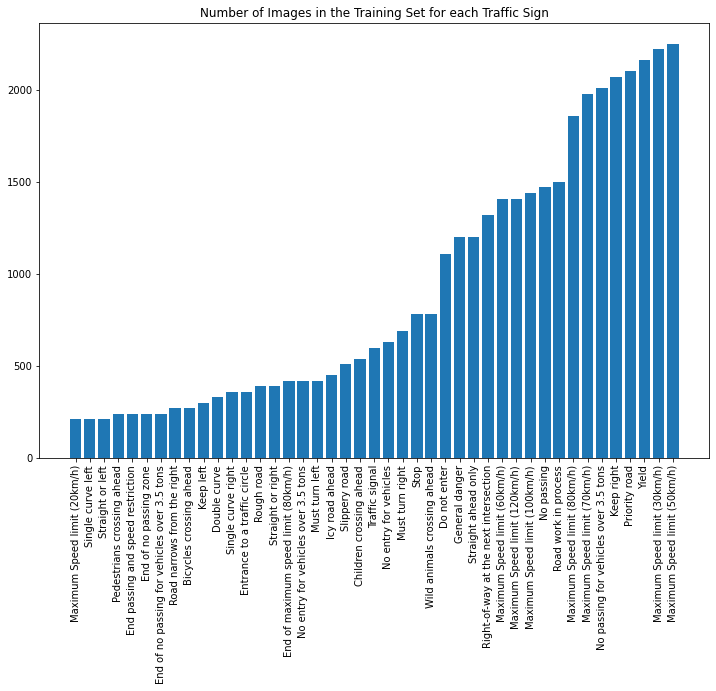

In [11]:
plt.figure(figsize=(12,8))
plt.bar(num_each_class_sorted.keys(), num_each_class_sorted.values())
plt.xticks(list(num_each_class_sorted.keys()), rotation='vertical')
plt.title('Number of Images in the Training Set for each Traffic Sign')
plt.show()

Notice that the distribution of training images are uneven.

Then let's see some random test images.

In [12]:
# Load images paths from the csv file
test_csv = pd.read_csv('./Test.csv')
test_images = test_csv['Path'].values
test_labels = test_csv['ClassId'].values

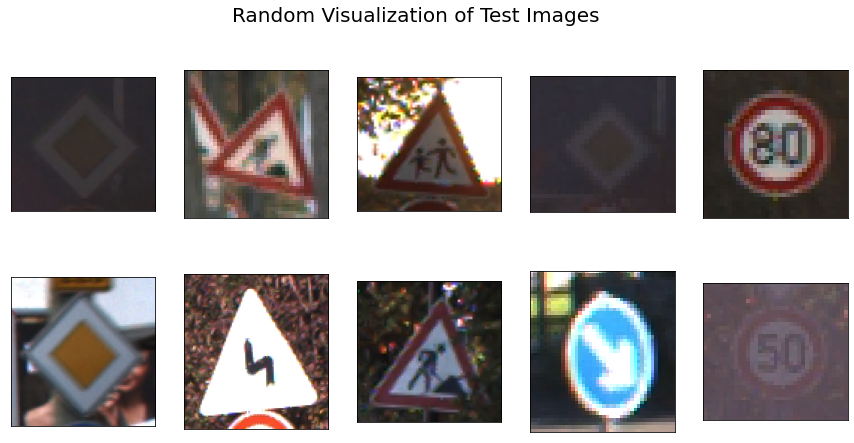

In [13]:
plt.figure(figsize=(15, 7))
random.seed(418)
plt.suptitle('Random Visualization of Test Images', fontsize=20)
for i in range(1,11):
    plt.subplot(2,5,i)
    random_image_path = os.path.join(os.getcwd(), random.choice(test_images))
    img = mpimg.imread(random_image_path)
    plt.imshow(img)
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])

[Back to top](#top)

<a id='cnn'></a>
## 3 Build a CNN Model

### 3.1 Create our own architecture

Before we build our model, let's first create and configure an augmented image generator to ensure that our model receives different variations of images.

In [14]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 128)         0

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 3.2 Transfer learning with VGG19

In [30]:
model_VGG19 = Sequential()

model_VGG19.add(VGG19(weights='imagenet', include_top=False, input_shape=(50, 50, 3)))
model_VGG19.add(BatchNormalization(axis=-1))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(1024, activation='relu'))
model_VGG19.add(Dense(num_classes, activation='softmax'))

model_VGG19.summary()

80142336/80134624 [==============================] - 10s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 43)                44075     
Total params: 20,595,819
Trainable params: 20,594,795
Non-trainable params: 1,024
_________________________________________________________________


In [31]:
model_VGG19.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

[Back to top](#top)

<a id='train'></a>
## 4 Train and Validate the Model

In [16]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
training.shape

(39209, 50, 50, 3)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(training, labels_, test_size=0.3, random_state=418)

print(' X_train: ', X_train.shape, '\n', \
    'X_val: ', X_val.shape, '\n', \
    'y_train: ', y_train.shape, '\n', \
    'y_val: ', y_val.shape)

 X_train:  (27446, 50, 50, 3) 
 X_val:  (11763, 50, 50, 3) 
 y_train:  (27446, 43) 
 y_val:  (11763, 43)


In [19]:
X_train = X_train / 255
X_val = X_val / 255

### 4.1 Own architecture

In [21]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=datagen.flow(X_val, y_val))

Epoch 1/15
858/858 [==============================] - 71s 83ms/step - loss: 1.1158 - accuracy: 0.6587 - val_loss: 0.4955 - val_accuracy: 0.8382
Epoch 2/15
858/858 [==============================] - 73s 86ms/step - loss: 0.4209 - accuracy: 0.8653 - val_loss: 0.3127 - val_accuracy: 0.8980
Epoch 3/15
858/858 [==============================] - 74s 86ms/step - loss: 0.2739 - accuracy: 0.9103 - val_loss: 0.2085 - val_accuracy: 0.9305
Epoch 4/15
858/858 [==============================] - 73s 85ms/step - loss: 0.2268 - accuracy: 0.9260 - val_loss: 0.2213 - val_accuracy: 0.9299
Epoch 5/15
858/858 [==============================] - 74s 86ms/step - loss: 0.2017 - accuracy: 0.9338 - val_loss: 0.1822 - val_accuracy: 0.9403
Epoch 6/15
858/858 [==============================] - 74s 86ms/step - loss: 0.1681 - accuracy: 0.9439 - val_loss: 0.1381 - val_accuracy: 0.9524
Epoch 7/15
858/858 [==============================] - 75s 88ms/step - loss: 0.1666 - accuracy: 0.9431 - val_loss: 0.1578 - val_accuracy:

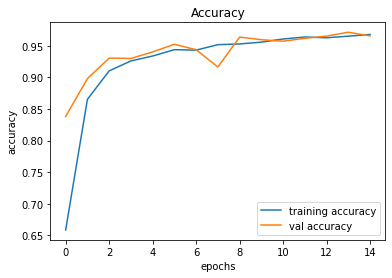

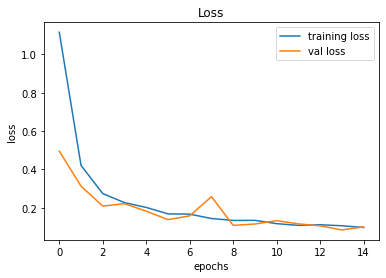

In [22]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### 4.2 VGG19

In [33]:
history_VGG19 = model_VGG19.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=datagen.flow(X_val, y_val))

Epoch 1/10
858/858 [==============================] - 777s 905ms/step - loss: 2.8589 - accuracy: 0.1687 - val_loss: 255.4770 - val_accuracy: 0.0940
Epoch 2/10
858/858 [==============================] - 776s 905ms/step - loss: 1.9620 - accuracy: 0.3335 - val_loss: 567.2181 - val_accuracy: 0.2826
Epoch 3/10
858/858 [==============================] - 778s 906ms/step - loss: 1.5590 - accuracy: 0.4578 - val_loss: 2746.4690 - val_accuracy: 0.4987
Epoch 4/10
858/858 [==============================] - 826s 963ms/step - loss: 1.1721 - accuracy: 0.5789 - val_loss: 5.8162 - val_accuracy: 0.4969
Epoch 5/10
858/858 [==============================] - 849s 989ms/step - loss: 0.9003 - accuracy: 0.6744 - val_loss: 10777.8604 - val_accuracy: 0.6011
Epoch 6/10
858/858 [==============================] - 838s 977ms/step - loss: 0.6494 - accuracy: 0.7719 - val_loss: 623.6337 - val_accuracy: 0.7951
Epoch 7/10
858/858 [==============================] - 792s 923ms/step - loss: 0.4742 - accuracy: 0.8371 - val_l

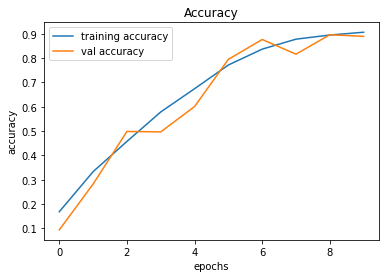

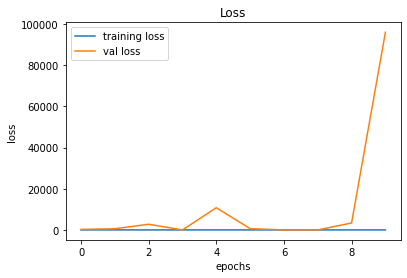

In [34]:
plt.figure(0)
plt.plot(history_VGG19.history['accuracy'], label='training accuracy')
plt.plot(history_VGG19.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history_VGG19.history['loss'], label='training loss')
plt.plot(history_VGG19.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Prediction

In [35]:
# Obtain labels and paths for test images
test_csv = pd.read_csv('./Test.csv')
test_labels = test_csv['ClassId'].values
test_images_path = test_csv['Path'].values

In [25]:
test_images = []
for i in test_images_path.tolist():
    img = load_img(os.path.join(os.getcwd(),  str(i)), target_size=(50, 50))
    image = img_to_array(img)
    test_images.append(image)

In [26]:
X_test = np.array(test_images) / 255

pred = np.argmax(model.predict(X_test), axis=-1)

In [27]:
print("Test Data Accuracy: ", accuracy_score(test_labels, pred))

Test Data Accuracy:  0.9462391132224861


In [36]:
X_test = np.array(test_images) / 255

pred_VGG19 = np.argmax(model_VGG19.predict(X_test), axis=-1)

In [37]:
print("Test Data Accuracy: ", accuracy_score(test_labels, pred_VGG19))

Test Data Accuracy:  0.8749802058590657


In [28]:
# Save the model
model.save('model_cnn.h5')

In [38]:
# Save the model
model_VGG19.save('model_VGG19.h5')